<h1><center>Sprint 7</center></h1>
<h2><center>Tasca 1: Algoritmes d’aprenentatge supervisat: Classificació.</center></h2>

In [1]:
# Packages
from pathlib import Path
import numpy as np
import pandas as pd
from scipy import stats
import math
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import itertools

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier

In [2]:
# file paths
data_path = 'D:/Sistema_Solar/Python/itacademy/sprint07/data/'
data_path = Path(data_path)

- Exercici 1
Crea almenys dos models de classificació diferents per intentar predir el millor les classes de l'arxiu adjunt.



- Exercici 2
Compara els models de classificació utilitzant la precisió (accuracy), una matriu de confusió i d’altres mètriques més avançades.



- Exercici 3
Entrena’ls usant els diferents paràmetres que admeten per tal de millorar-ne la predicció.



- Exercici 4
Compara el seu rendiment fent servir l’aproximació traint/test o cross-validation.



- Exercici 5
Aplica algun procés d'enginyeria per millorar els resultats (normalització, estandardització, mostreig...)

In [3]:
# Apugem l'arxiu csv
file_name = 'wineData.txt'
file = data_path / file_name
wines = pd.read_csv(file, sep=',', header=None, encoding="ISO-8859-1")

# Afegim els noms de les columnes
colnames = ['Class', 'Alcohol', 'Malic', 'Ash', 'Alcalinity', 'Mg', 'Total phenols', 'Flavanoids', 'Nonflavanoids', 'Proanthocyanins', 'Color intensity', 'Hue', 'OD280/OD315', 'Proline']
wines.columns = colnames

In [4]:
wines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Class            178 non-null    int64  
 1   Alcohol          178 non-null    float64
 2   Malic            178 non-null    float64
 3   Ash              178 non-null    float64
 4   Alcalinity       178 non-null    float64
 5   Mg               178 non-null    int64  
 6   Total phenols    178 non-null    float64
 7   Flavanoids       178 non-null    float64
 8   Nonflavanoids    178 non-null    float64
 9   Proanthocyanins  178 non-null    float64
 10  Color intensity  178 non-null    float64
 11  Hue              178 non-null    float64
 12  OD280/OD315      178 non-null    float64
 13  Proline          178 non-null    int64  
dtypes: float64(11), int64(3)
memory usage: 19.6 KB


In [5]:
print(wines.describe())

            Class     Alcohol       Malic         Ash  Alcalinity          Mg  \
count  178.000000  178.000000  178.000000  178.000000  178.000000  178.000000   
mean     1.938202   13.000618    2.336348    2.366517   19.494944   99.741573   
std      0.775035    0.811827    1.117146    0.274344    3.339564   14.282484   
min      1.000000   11.030000    0.740000    1.360000   10.600000   70.000000   
25%      1.000000   12.362500    1.602500    2.210000   17.200000   88.000000   
50%      2.000000   13.050000    1.865000    2.360000   19.500000   98.000000   
75%      3.000000   13.677500    3.082500    2.557500   21.500000  107.000000   
max      3.000000   14.830000    5.800000    3.230000   30.000000  162.000000   

       Total phenols  Flavanoids  Nonflavanoids  Proanthocyanins  \
count     178.000000  178.000000     178.000000       178.000000   
mean        2.295112    2.029270       0.361854         1.590899   
std         0.625851    0.998859       0.124453         0.572359  

In [6]:
wines_matrix = wines.corr()

# Eliminarem les correlacions entre iguals per millorar la visualització posterior
for i in range(len(wines_matrix.columns)):
    for j in range(len(wines_matrix.columns)):
        if i == j:
            wines_matrix.iloc[i][j] = np.nan

<AxesSubplot:>

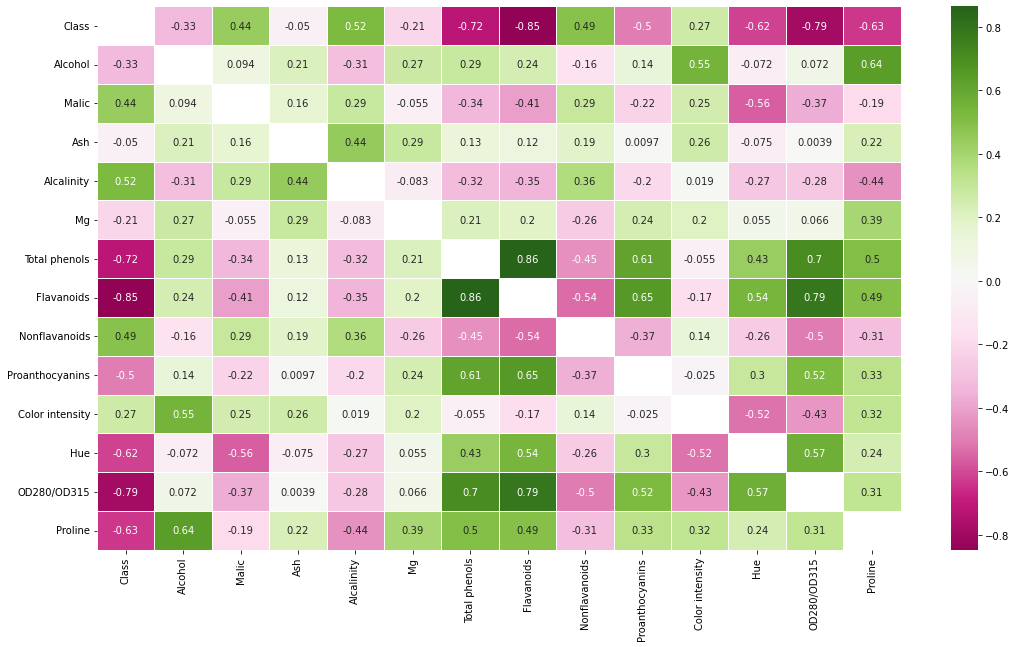

In [7]:
fig, ax = plt.subplots(figsize=(18,10))         # Sample figsize in inches
#sns.heatmap(df1.iloc[:, 1:6:], annot=True, linewidths=.5, ax=ax)

sns.heatmap(wines_matrix, annot=True, linewidth=.5, ax=ax, cmap="PiYG", center=0)

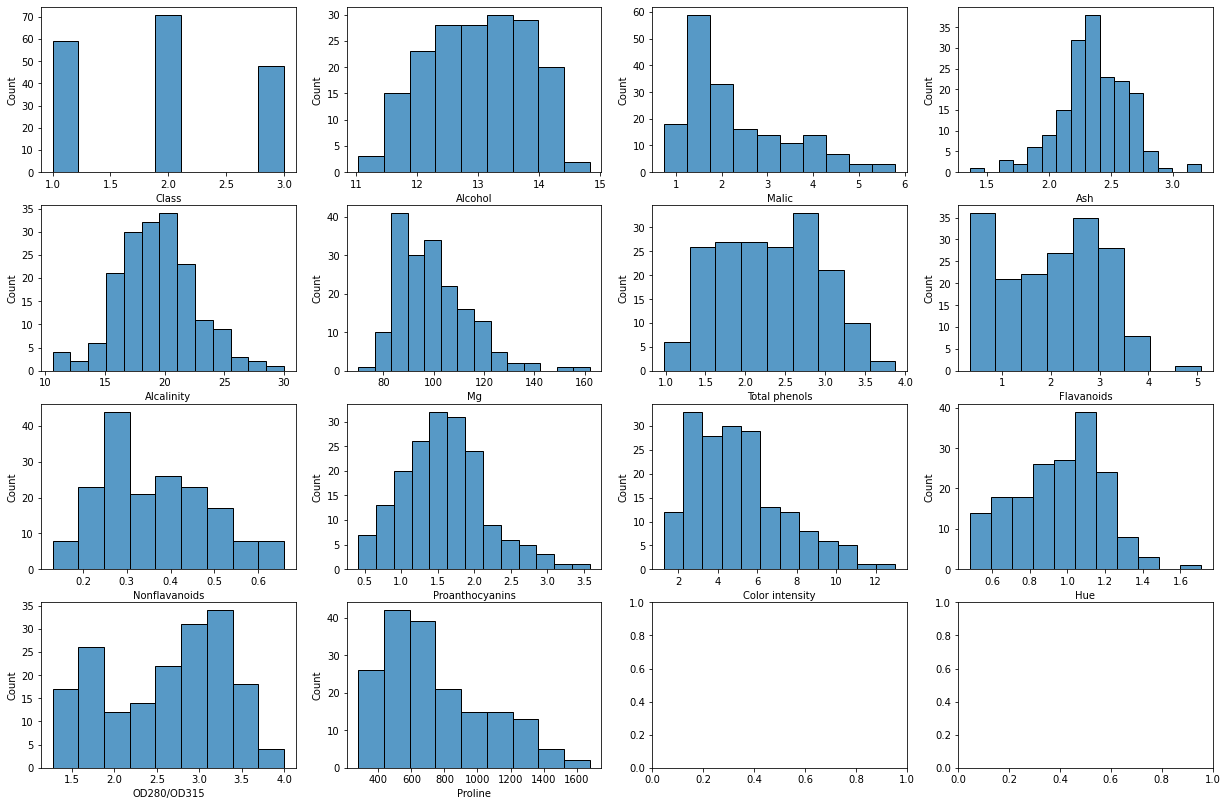

In [8]:
fig, ax = plt.subplots(4, 4, figsize=(21,14))
nrow = 0
ncol = 0

for col in wines_matrix.columns:
    sns.histplot(wines[col], ax=ax[nrow][ncol])
    ncol += 1
    if ncol == 4:
        nrow += 1
        ncol = 0

In [9]:
# Dataframe on emmagatzarem els coeficients MSE i R2 per comparar els diferents models.

coef_df = pd.DataFrame(index = ['Accuracy', 'Precission', 'Recall', 'Fbeta', 'F1score'])

#### 1. Model d'arbre de decisió

In [10]:
# Separem el dataframe en un conjunt per entrenar el model i un altre per aplicar-lo.
wines_train, wines_test = train_test_split(wines, test_size=0.2, random_state=42)

In [11]:
col_sel = ['Alcohol', 'Malic', 'Alcalinity', 'Total phenols', 'Flavanoids', 'Nonflavanoids', 'Proanthocyanins', 'Hue', 'OD280/OD315', 'Proline']

x_train = wines_train[col_sel]
y_train = wines_train['Class']

x_test = wines_test[col_sel]
y_test = wines_test['Class']

In [12]:
dt = DecisionTreeClassifier()

dt.fit(x_train, y_train)
dt_depth = dt.get_depth()
print(f'Decision Tree depth: {dt_depth}')
y_pred = dt.predict(x_test)
y_pred_train = dt.predict(x_train)

Decision Tree depth: 4


1. Alcohol
2. Malic
3. Alcalinity
4. Total phenols
5. Flavanoids
6. Nonflavanoids
7. Proanthocyanins
8. Hue
9. OD280/OD315
10. Proline

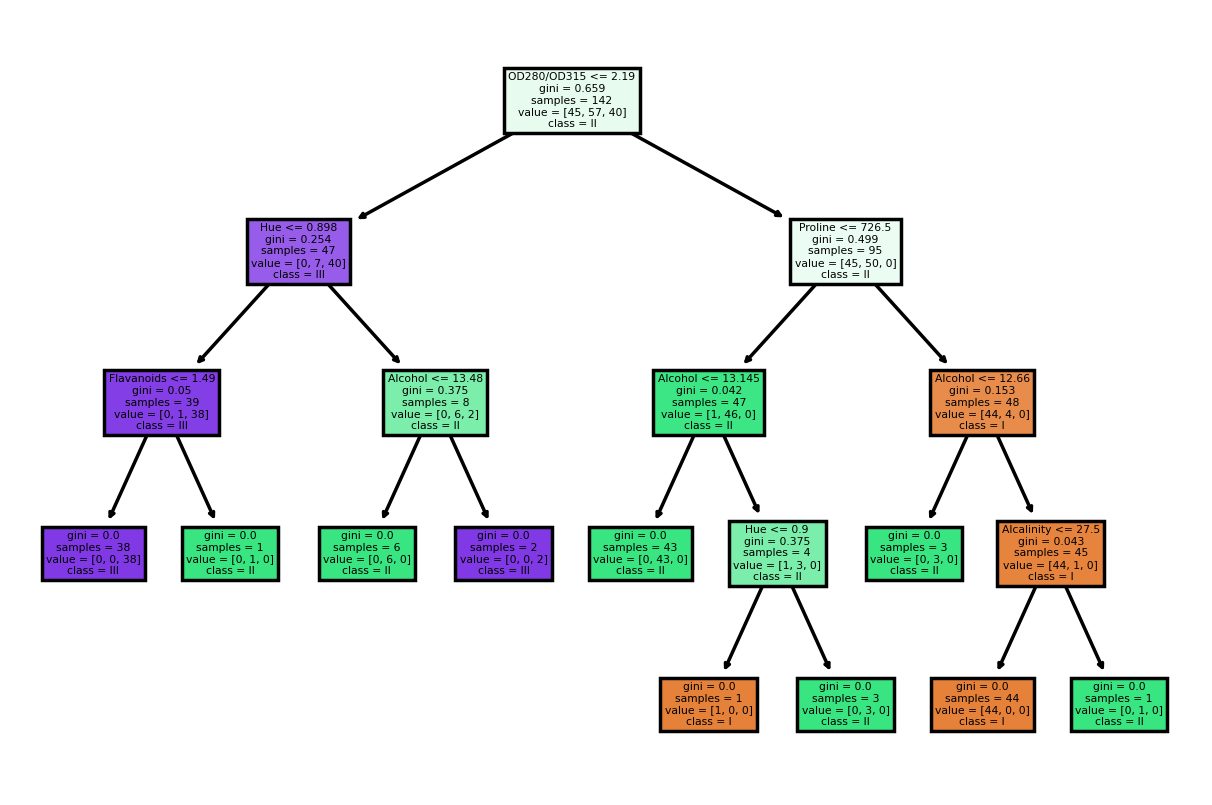

In [13]:
plt.figure(dpi=250)

cn = ['I', 'II', 'III'] 

plt.show(tree.plot_tree(dt,
               feature_names = col_sel, 
               class_names=cn,
               filled = True))

In [14]:
# Avaluació del model

from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

# accuracy
dt_score = dt.score(x_test, y_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Test set accuracy tree no max depth: {np.round(dt_score, 2)}')# or accuracy_score(y_test, y_pred)
print(f'model accuracy: {np.round(accuracy, 2)}')

# confusion matrix

confusion_train = confusion_matrix(y_train, y_pred_train, labels=[1, 2, 3])
confusion_test = confusion_matrix(y_test, y_pred, labels=[1, 2, 3])

Test set accuracy tree no max depth: 0.89
model accuracy: 0.89


In [15]:
from sklearn.metrics import classification_report


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[45  0  0]
 [ 0 57  0]
 [ 0  0 40]]


C:\Users\Carles\AppData\Local\Temp\ipykernel_11344\2544922135.py:22: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


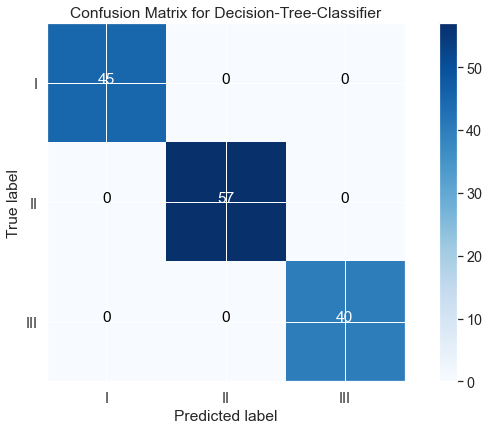

In [16]:
plt.figure(figsize=(10, 6))
sns.set(font_scale=1.3)
plot_confusion_matrix(confusion_train, 
                      classes=['I','II', 'III'],
                      normalize= False,  
                      title='Confusion Matrix for Decision-Tree-Classifier')

Confusion matrix, without normalization
[[14  0  0]
 [ 0 13  1]
 [ 1  2  5]]


C:\Users\Carles\AppData\Local\Temp\ipykernel_11344\2544922135.py:22: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


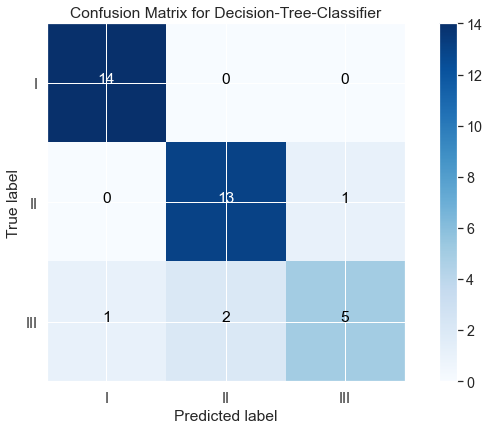

In [17]:
plt.figure(figsize=(10, 6))
sns.set(font_scale=1.3)
plot_confusion_matrix(confusion_test, 
                      classes=['I','II', 'III'], ######## aqui canviar
                      normalize= False,  
                      title='Confusion Matrix for Decision-Tree-Classifier')

In [18]:
precision = precision_recall_fscore_support(y_test, y_pred, average='macro')[0]
recall = precision_recall_fscore_support(y_test, y_pred, average='macro')[1]
fbeta = precision_recall_fscore_support(y_test, y_pred, average='macro')[2]
f1score = f1_score(y_test, y_pred, average='micro')
print(f'Precision: {np.round(precision, 2)}')
print(f'Recall: {np.round(recall, 2)}')
print(f'fbeta: {np.round(fbeta, 2)}')
print(f'F1 score: {np.round(f1score, 2)}')

Precision: 0.88
Recall: 0.85
fbeta: 0.86
F1 score: 0.89


In [19]:
coef_df['DecTree_O'] = [np.round(accuracy,2), np.round(precision, 2), np.round(recall, 2), np.round(fbeta, 2), np.round(f1score, 2)]

In [20]:
coef_df

,DecTree_O
Accuracy,0.89
Precission,0.88
Recall,0.85
Fbeta,0.86
F1score,0.89


El número de nivells de divisions d'aquest model era de 4, pero podem aconseguir diferents resultats si ajustem aquest paràmetre.

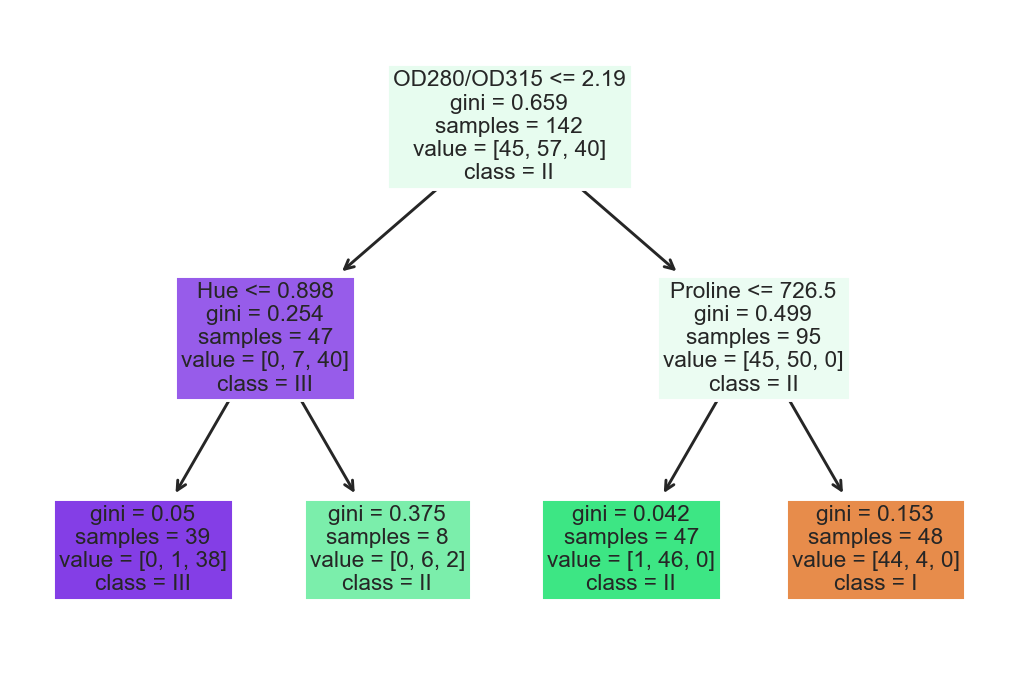

Decision Tree depth: 2
model accuracy: 0.92
Precision: 0.91
Recall: 0.89
fbeta: 0.9
F1 score: 0.92
----------------


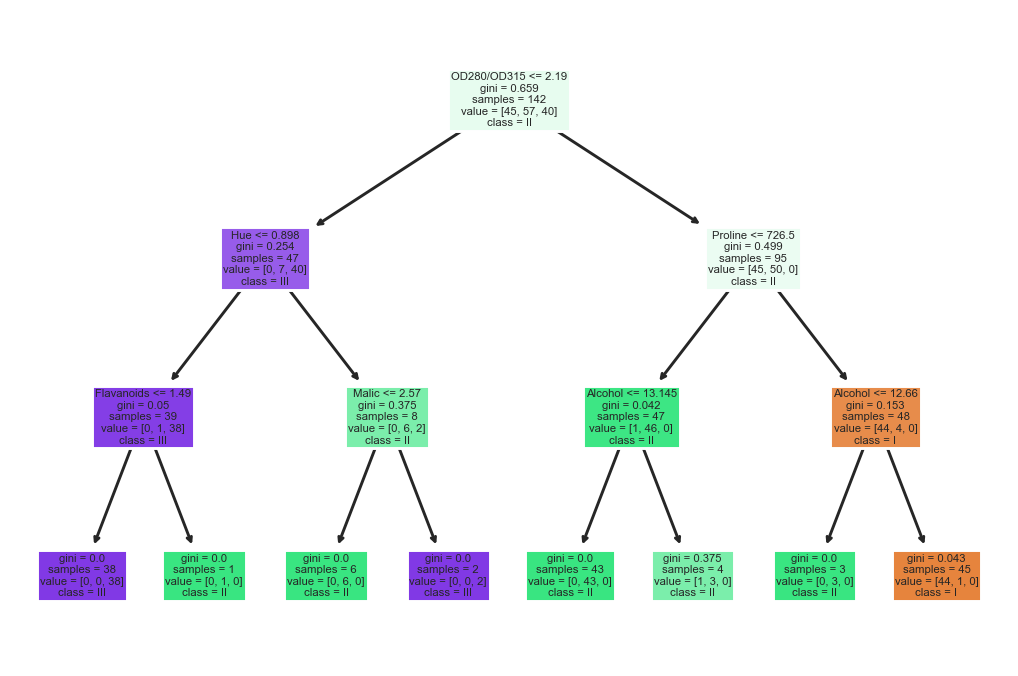

Decision Tree depth: 3
model accuracy: 0.89
Precision: 0.88
Recall: 0.85
fbeta: 0.86
F1 score: 0.89
----------------


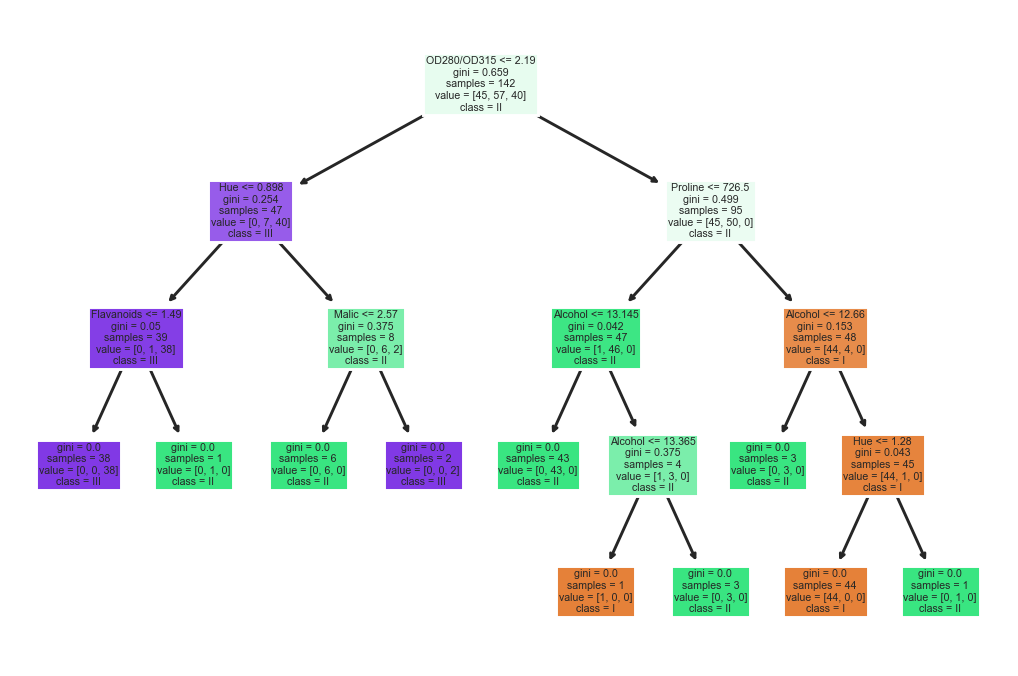

Decision Tree depth: 4
model accuracy: 0.89
Precision: 0.88
Recall: 0.85
fbeta: 0.86
F1 score: 0.89
----------------


In [56]:
dpi_sel = [125, 210, 280]
for depth in range(2, 5):

    dt = DecisionTreeClassifier(max_depth=depth)

    dt.fit(x_train, y_train)
    dt_depth = dt.get_depth()
    y_pred = dt.predict(x_test)
    y_pred_train = dt.predict(x_train)


    plt.figure(dpi=dpi_sel[i-2])

    cn = ['I', 'II', 'III'] 

    plt.show(tree.plot_tree(dt,
                   feature_names = col_sel, 
                   class_names=cn,
                   filled = True))
    print(f'Decision Tree depth: {dt_depth}')
    accuracy = accuracy_score(y_test, y_pred)
    print(f'model accuracy: {np.round(accuracy, 2)}')
    
    # confusion matrix
    confusion_test = confusion_matrix(y_test, y_pred, labels=[1, 2, 3])
    
    precision = precision_recall_fscore_support(y_test, y_pred, average='macro')[0]
    recall = precision_recall_fscore_support(y_test, y_pred, average='macro')[1]
    fbeta = precision_recall_fscore_support(y_test, y_pred, average='macro')[2]
    f1score = f1_score(y_test, y_pred, average='micro')
    print(f'Precision: {np.round(precision, 2)}')
    print(f'Recall: {np.round(recall, 2)}')
    print(f'fbeta: {np.round(fbeta, 2)}')
    print(f'F1 score: {np.round(f1score, 2)}')
    print('----------------')
    

El model es comporta millor quan menys divisions es fan. En concret, amb dos divisons. Tot i així, veiem que el valor gni de algunes fulles finals, és superior a 0 mentre que si dividim més l'arbre la impuressa es reduix, a banda que es precindeixen de massa variables ja que es fan poques divisions. 

In [ ]:
#Per tant, i com aquest test s'ha fet amb poques mostres. Ens quedarem amb un max_depth=3.

#### 2. Model k-nearest neighbors

In [22]:
# Caldrà normalitzar, però ho farem per a l'exercici 5 

In [23]:
classifier = KNeighborsClassifier(n_neighbors=10)

classifier.fit(x_train, y_train)

unknown_points = x_test

y_pred = classifier.predict(unknown_points)

In [24]:
len(x_test['Alcohol'])

36

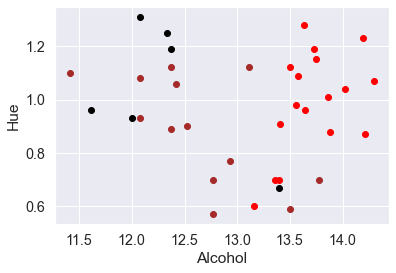

In [25]:
x = 'Alcohol'
y = 'Hue'

d = {x:x_test[x], y:x_test[y], 'y_pred':y_pred}
plot_df = pd.DataFrame(data = d)

colors = ['red', 'brown', 'black']
for i in range(1, 4):
    filter = plot_df['y_pred'] == i
    plot_class = plot_df[filter]
    plt.scatter(plot_class[x], plot_class[y],  c=colors[i-1])
    plt.xlabel(x)
    plt.ylabel(y)

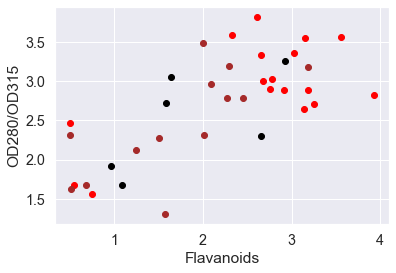

In [26]:
x = 'Flavanoids'
y = 'OD280/OD315'

d = {x:x_test[x], y:x_test[y], 'y_pred':y_pred}
plot_df = pd.DataFrame(data = d)

colors = ['red', 'brown', 'black']
for i in range(1, 4):
    filter = plot_df['y_pred'] == i
    plot_class = plot_df[filter]
    plt.scatter(plot_class[x], plot_class[y],  c=colors[i-1])
    plt.xlabel(x)
    plt.ylabel(y)

In [27]:
accuracy = accuracy_score(y_test, y_pred)
print(f'model accuracy: {accuracy}')

# confusion matrix

confusion_test = confusion_matrix(y_test, y_pred, labels=[1, 2, 3])

model accuracy: 0.6666666666666666


Confusion matrix, without normalization
[[14  0  0]
 [ 0  9  5]
 [ 3  4  1]]


C:\Users\Carles\AppData\Local\Temp\ipykernel_11344\2544922135.py:22: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


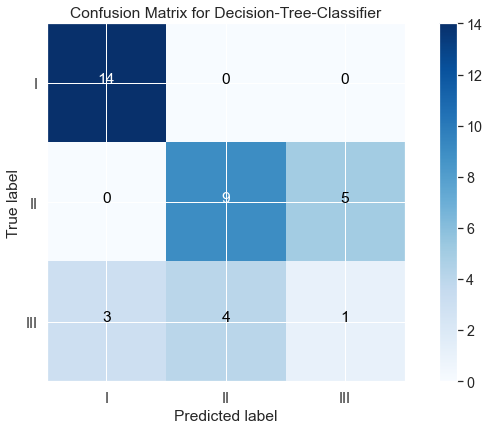

In [28]:
plt.figure(figsize=(10, 6))
sns.set(font_scale=1.3)
plot_confusion_matrix(confusion_test, 
                      classes=['I','II', 'III'],
                      normalize= False,  
                      title='Confusion Matrix for Decision-Tree-Classifier')

In [29]:
precision = precision_recall_fscore_support(y_test, y_pred, average='macro')[0]
recall = precision_recall_fscore_support(y_test, y_pred, average='macro')[1]
fbeta = precision_recall_fscore_support(y_test, y_pred, average='macro')[2]
print(f'Precision: {np.round(precision, 2)}')
print(f'Recall: {np.round(recall, 2)}')
print(f'fbeta: {np.round(fbeta, 2)}')
f1score = f1_score(y_test, y_pred, average='micro')
print(f'F1 score: {np.round(f1score, 2)}')

Precision: 0.56
Recall: 0.59
fbeta: 0.57
F1 score: 0.67


In [30]:
coef_df['NK_O'] = [np.round(accuracy,2), np.round(precision, 2), np.round(recall, 2), np.round(fbeta, 2), np.round(f1score, 2)]

In [31]:
coef_df

,DecTree_O,NK_O
Accuracy,0.89,0.67
Precission,0.88,0.56
Recall,0.85,0.59
Fbeta,0.86,0.57
F1score,0.89,0.67


En el cas d'aquest últim model, convé normalitzar les dades d'entrada per a què aquelles variables que amb números d'ordre superiors no afecten més que d'altres.

In [32]:
col_sel = ['Alcohol', 'Malic', 'Alcalinity', 'Total phenols', 'Flavanoids', 'Nonflavanoids', 'Proanthocyanins', 'Hue', 'OD280/OD315', 'Proline']

mmscaler = MinMaxScaler()

for col in col_sel:
    
    reshaped = np.array(wines[col]).reshape(-1,1)
    
    normalized = mmscaler.fit_transform(reshaped)
    
    if col == 'Alcohol':
        wines_norm = pd.DataFrame(normalized, columns=[col])
    else:
        wines_norm[col] = normalized
    
# Separem el dataframe en un conjunt per entrenar el model i un altre per aplicar-lo.
wines_train_n, wines_test_n = train_test_split(wines_norm, test_size=0.2, random_state=42)

x_train_n = wines_train_n[col_sel]
x_test_n = wines_test_n[col_sel]

In [33]:
x_train_n

,Alcohol,Malic,Alcalinity,Total phenols,Flavanoids,Nonflavanoids,Proanthocyanins,Hue,OD280/OD315,Proline
158,0.871053,0.185771,0.742268,0.627586,0.204641,0.754717,0.722397,0.073171,0.252747,0.272468
137,0.394737,0.942688,0.742268,0.279310,0.054852,0.943396,0.217666,0.276423,0.153846,0.169044
98,0.352632,0.065217,0.407216,0.875862,0.719409,0.207547,0.485804,0.455285,0.549451,0.272468
159,0.644737,0.183794,0.613402,0.558621,0.160338,0.735849,0.593060,0.073171,0.186813,0.243937
38,0.536842,0.150198,0.252577,0.489655,0.485232,0.283019,0.302839,0.569106,0.520147,0.529244
...,...,...,...,...,...,...,...,...,...,...
71,0.744737,0.152174,0.742268,0.679310,0.531646,0.150943,0.460568,0.715447,0.692308,0.094151
106,0.321053,0.195652,0.432990,0.231034,0.356540,0.452830,0.384858,0.422764,0.695971,0.165478
14,0.881579,0.223320,0.072165,0.800000,0.696203,0.301887,0.804416,0.585366,0.633700,0.905136
92,0.436842,0.156126,0.520619,0.137931,0.236287,0.849057,0.381703,0.390244,0.289377,0.154779


In [34]:
classifier = KNeighborsClassifier(n_neighbors=10)
classifier.fit(x_train_n, y_train)
unknown_points = x_test_n
y_pred = classifier.predict(unknown_points)

In [35]:
y_train

158    3
137    3
98     2
159    3
38     1
      ..
71     2
106    2
14     1
92     2
102    2
Name: Class, Length: 142, dtype: int64

In [36]:
accuracy = accuracy_score(y_test, y_pred)
print(f'model accuracy: {accuracy}')

# confusion matrix

confusion_test = confusion_matrix(y_test, y_pred, labels=[1, 2, 3])

model accuracy: 0.9444444444444444


Confusion matrix, without normalization
[[14  0  0]
 [ 1 12  1]
 [ 0  0  8]]


C:\Users\Carles\AppData\Local\Temp\ipykernel_11344\2544922135.py:22: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


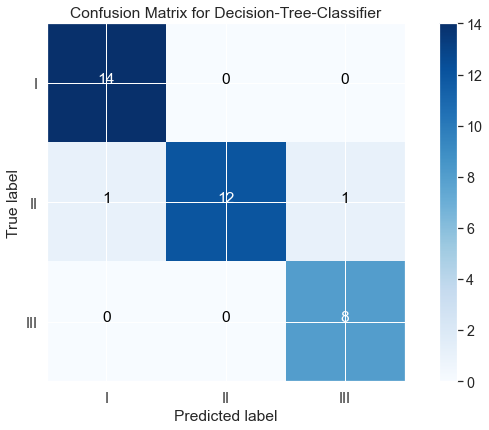

In [37]:
plt.figure(figsize=(10, 6))
sns.set(font_scale=1.3)
plot_confusion_matrix(confusion_test, 
                      classes=['I','II', 'III'],
                      normalize= False,  
                      title='Confusion Matrix for Decision-Tree-Classifier')

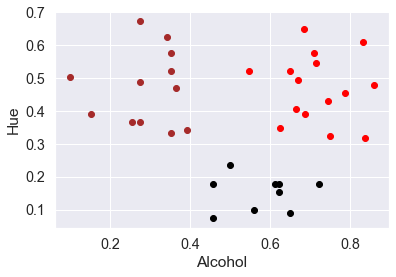

In [38]:
x = 'Alcohol'
y = 'Hue'

d = {x:x_test_n[x], y:x_test_n[y], 'y_pred':y_pred}
plot_df = pd.DataFrame(data = d)

colors = ['red', 'brown', 'black']
for i in range(1, 4):
    filter = plot_df['y_pred'] == i
    plot_class = plot_df[filter]
    plt.scatter(plot_class[x], plot_class[y],  c=colors[i-1])
    plt.xlabel(x)
    plt.ylabel(y)

In [39]:
y_pred

array([1, 1, 3, 1, 2, 1, 2, 3, 2, 3, 1, 3, 1, 3, 1, 2, 2, 2, 1, 2, 1, 1,
       2, 3, 3, 3, 2, 2, 2, 1, 1, 2, 3, 1, 1, 1], dtype=int64)

In [40]:
x_test_n['Alcohol']

19     0.686842
45     0.836842
140    0.500000
30     0.710526
67     0.352632
16     0.860526
119    0.255263
174    0.623684
109    0.152632
141    0.613158
24     0.650000
150    0.650000
41     0.626316
118    0.457895
15     0.684211
111    0.392105
113    0.100000
82     0.276316
9      0.744737
114    0.276316
18     0.831579
66     0.547368
60     0.342105
169    0.623684
171    0.457895
164    0.723684
117    0.365789
65     0.352632
90     0.276316
55     0.665789
29     0.786842
128    0.352632
145    0.560526
31     0.671053
12     0.715789
42     0.750000
Name: Alcohol, dtype: float64

In [41]:
y_pred

array([1, 1, 3, 1, 2, 1, 2, 3, 2, 3, 1, 3, 1, 3, 1, 2, 2, 2, 1, 2, 1, 1,
       2, 3, 3, 3, 2, 2, 2, 1, 1, 2, 3, 1, 1, 1], dtype=int64)

In [42]:
precision = precision_recall_fscore_support(y_test, y_pred, average='macro')[0]
recall = precision_recall_fscore_support(y_test, y_pred, average='macro')[1]
fbeta = precision_recall_fscore_support(y_test, y_pred, average='macro')[2]
print(f'Precision: {np.round(precision, 2)}')
print(f'Recall: {np.round(recall, 2)}')
print(f'fbeta: {np.round(fbeta, 2)}')
f1score = f1_score(y_test, y_pred, average='micro')
print(f'F1 score: {np.round(f1score, 2)}')

Precision: 0.94
Recall: 0.95
fbeta: 0.94
F1 score: 0.94


In [43]:
coef_df['NK_Normalized'] = [np.round(accuracy,2), np.round(precision, 2), np.round(recall, 2), np.round(fbeta, 2), np.round(f1score, 2)]

In [44]:
coef_df

,DecTree_O,NK_O,NK_Normalized
Accuracy,0.89,0.67,0.94
Precission,0.88,0.56,0.94
Recall,0.85,0.59,0.95
Fbeta,0.86,0.57,0.94
F1score,0.89,0.67,0.94


El rendiment millora de manera molt notable

En el model KN s'ha d'elegir el número de n_neighbours, a mesura que utilitzem un número menor, podem incrementar la precisió del model però podem acabar sobreajustant el model. Iterarem augmentant de manera progresiva per veure com reacciona el model als diferents valors de n_neighbours

In [45]:
accuracy_k = []

for k in range(1, 11):
    classifier = KNeighborsClassifier(n_neighbors=k)
    classifier.fit(x_train_n, y_train)
    unknown_points = x_test_n
    y_pred = classifier.predict(unknown_points)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_k.append(accuracy)

In [46]:
accuracy_k

[0.9444444444444444,
 0.9444444444444444,
 0.9444444444444444,
 0.9444444444444444,
 0.9444444444444444,
 0.9444444444444444,
 0.9722222222222222,
 0.9444444444444444,
 0.9444444444444444,
 0.9444444444444444]

En aquest cas, les diferències entre les diferents classes son tan notables que la precisió quasi no varia, anem a elegir, però una k superior a 1, ja que el model agafe de referència sols el valor més proper per a categoritzar una mostra, pot produir overfitting.

In [49]:
k = 5

classifier = KNeighborsClassifier(n_neighbors=k)
classifier.fit(x_train_n, y_train)
unknown_points = x_test_n
y_pred = classifier.predict(unknown_points)
accuracy = accuracy_score(y_test, y_pred)

coef_df['NK_Normalized_k5'] = [np.round(accuracy,2), np.round(precision, 2), np.round(recall, 2), np.round(fbeta, 2), np.round(f1score, 2)]